In [3]:
# Importando Librerias

import pandas as pd
import os, string, unicodedata, re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.util import ngrams
import nltk
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import random
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns



#

# **1. RECLASIFICANDO df_csv con df_clasificador**

## **1.1 Leyendo los archivos**

In [4]:
df_csv =  pd.read_csv('informacion_roles_actualizado.csv')

df_clasificador = pd.read_excel('CLASIFICADO_FINAL.xlsx')

- `df_csv`: Contiene los datos que tenemos que reclasificar con el dataframe df_clasificador
- `df_clasificador` corresponde al df donde se encuentran las etiquetas bien clasificadas

In [5]:
df_csv.head()

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso
0,144280-2022,Valparaíso,05/02/2024,26.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
1,144280-2022,Valparaíso,05/02/2024,25.0,Actuación,COMUNICA CÚMPLASE CS,31/10/2022
2,144280-2022,Valparaíso,05/02/2024,24.0,Resolución,Cúmplase CS,31/10/2022
3,144280-2022,Valparaíso,05/12/2023,23.0,Escrito,Recurso fallado Corte Suprema,31/10/2022
4,144280-2022,Valparaíso,15/06/2023,22.0,Resolución,(NMV)Concede Recurso (Intercon,31/10/2022


In [6]:
df_clasificador.head()

,Unnamed: 0,Descripcion,CLASIFICACION_FINAL
0,1461,Cumple lo ordenado / En Relaci,Téngase presente
1,202,Rec.Prot/D.cta.ONI.Sala Isapre,Dese cuenta
2,200,Cumple previo/Admisible GES,Admisibles
3,2621,Cambio código a masivo,ICA informa
4,1095,ocúrrase donde corresonda,ICA informa


## **1.2 Tratando los dfs**

In [7]:
df_clasificador['CLASIFICACION_FINAL'] = df_clasificador['CLASIFICACION_FINAL'].str.title()

In [8]:
df_clasificador['CLASIFICACION_FINAL'].value_counts()



CLASIFICACION_FINAL
Ica Solicita Diligencia    379
Agréguese A Tabla          319
Ica Informa                289
Evacua Informe             287
Admisibles                 255
Téngase Presente           203
Dese Cuenta                164
Apercibe                   160
Ica Amplia Plazo           138
Nhl                        119
Acoge                       69
Concede Apelación           54
Acuerdo                     43
Certifiquese                39
Cs                          38
Rechazada                   31
Art / Numeral               25
Archivado                   24
Fija Costas                 22
Inhabilidad                 22
Acumulación                 19
Oni                         17
Prescinde                   13
Inadmisible/Omite           13
Incompetencia               12
Multa                        7
Fallo/Desestima              5
Retira                       4
Inicio Tramitación           4
Name: count, dtype: int64

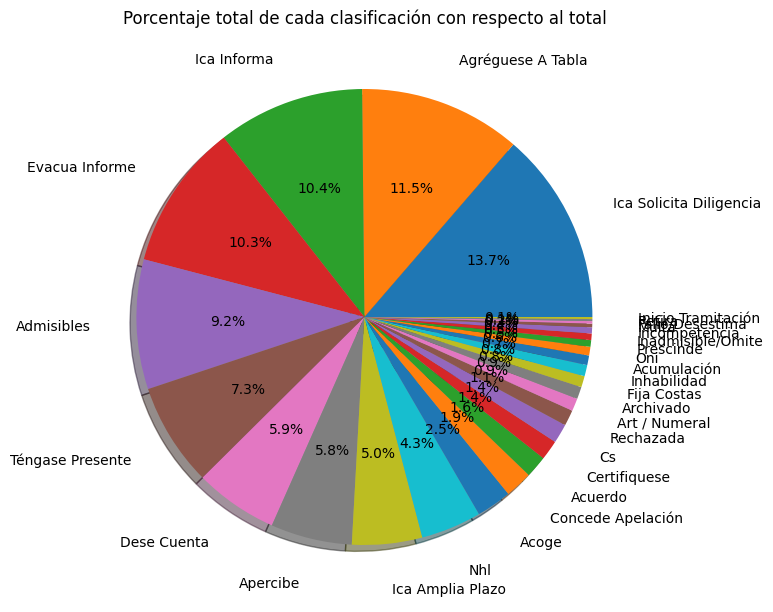

In [9]:
plt.figure(figsize=(10, 6))
plt.pie(df_clasificador['CLASIFICACION_FINAL'].value_counts(), labels=df_clasificador['CLASIFICACION_FINAL'].value_counts().index, autopct='%1.1f%%', labeldistance=1.2, normalize=True, shadow=True)
plt.tight_layout()
plt.title('Porcentaje total de cada clasificación con respecto al total')
plt.show()

- Tenemos bastante categorias que están muy poco presentes como es notorio en nuestro gráfico.
- Esto puede ser un problema considerando el desbalance de clases

### Generar el diccionario para CLASIFICACION FINAL - Descripción

In [10]:
# Genera un diccionario key = la clasificación correcta , value = todas los textos clasificados con esa etiqueta
dict_to_replace = df_clasificador.groupby('CLASIFICACION_FINAL')['Descripcion'].apply(list).to_dict()

- Cada descripción del dataframe se asocia a una respectiva categoria. Con esto podremos recategorizar el dataframe `df_csv`

In [11]:
# Función para reemplazar los datos
def mapear_valor(descripcion: str, diccionario: dict) -> str:

    """
    Toma un diccionario y ve si el valor está en en una cadena de texto. En caso de que esté devuelve la key del diccionario
    en caso de no encontrar concidencia entonces retorna el texto original
    """
    for key, values in diccionario.items():
        for value in values:
            if str(value).lower() in descripcion.lower():
                return key
    return descripcion 


### **CLASIFICANDO LOS VALORES DE df_csv con los valores de df_clasificador**

In [12]:
# Generando una nueva columna en el df que no se encuentra clasificado correctamente reempalzando sus valores según el diccionario clasificador
df_csv['CLASIFICACION_CORRECTA']=df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]['descripcion'].apply(lambda x: mapear_valor(x, dict_to_replace))

### **Solo dejando los registros en los cuales el trámite sea resolución o Sentencia**

In [13]:
df_csv = df_csv.loc[(df_csv['tramite']=='Resolución') | (df_csv['tramite']=='Sentencia'), :]

- Debido que en este problema solo nos interesa aquellos trámites que sean o Resolución o Sentencia, solo estos tipos de trámites son incluidos ya que las demás opciones son datos que no nos aportan ningun detalle a nuestro intento de predicciones

# **PROCESADO DEL TEXTO**

In [14]:
df_csv['dup_count'] = df_csv.groupby(['descripcion', 'CLASIFICACION_CORRECTA']).cumcount() + 1
max_veces = 3  

df_csv= df_csv[df_csv['dup_count'] <= max_veces]

In [15]:
# Obteniendo la lista de oraciones
sentences =  [ line for line in df_csv['descripcion'].values if line != 'Unknown']

In [16]:
sentences[:10]

['Cúmplase CS',
 '(NMV)Concede Recurso (Intercon',
 'NMV7/Acogida',
 'Agréguese Extraordinariamente',
 '7NMV/Estese al mérito',
 'nmv 3.Téngase Presente',
 '(8) Pide informe ONI',
 '(7)Estese al mérito de autos',
 '(5). Por Evacuado Informe, en',
 '(4)Interpuesto Recurso de Prot']

In [17]:
# Función para limpiar los textos
def cleaning_data(text):
    # Eliminar caracteres de puntuación
    clean_txt = "".join(char for char in text if char not in string.punctuation)
    
    # Normalizar el texto a ASCII
    text_normalized = unicodedata.normalize('NFKD', clean_txt).encode('ascii', 'ignore').decode('ascii')
    
    # Eliminar espacios adicionales y convertir a minúsculas
    text_cleaned = re.sub(r'\s{2,}', ' ', text_normalized).strip().lower()
    
    # Eliminar dígitos y palabras específicas (si no son útiles)
    text_cleaned = re.sub(r'^(\d+)\s|\d+(?=[a-zA-Z])', '', text_cleaned)  # Elimina números
    text_cleaned = re.sub(r'nmv', '', text_cleaned).strip()  # Elimina "nmv"
    
    return text_cleaned


In [18]:
# Oraciones limpias
clean_data = [cleaning_data(t) for t in sentences]

In [19]:
clean_data[:10]

['cumplase cs',
 'concede recurso intercon',
 'acogida',
 'agreguese extraordinariamente',
 'estese al merito',
 'tengase presente',
 'pide informe oni',
 'estese al merito de autos',
 'por evacuado informe en',
 'interpuesto recurso de prot']

## Eliminando las stopwords

In [20]:
import nltk
from nltk.corpus import stopwords

# Descargar las stopwords si no lo has hecho antes
nltk.download('stopwords')

# Obtener las stopwords en español
stop_words_es = set(stopwords.words('spanish'))

print(stop_words_es)

{'ti', 'tendréis', 'habríamos', 'tuvieron', 'estaba', 'hubo', 'vuestros', 'desde', 'tuviesen', 'estéis', 'habrán', 'fueseis', 'algunos', 'habíais', 'esa', 'ante', 'les', 'algunas', 'hayas', 'tenías', 'porque', 'sean', 'está', 'teníais', 'fuésemos', 'para', 'soy', 'eso', 'mi', 'estuvisteis', 'tengáis', 'la', 'tengamos', 'algo', 'estarán', 'estabais', 'hay', 'tuviésemos', 'esos', 'mías', 'tiene', 'nos', 'habrás', 'serán', 'no', 'estar', 'hubimos', 'tenga', 'tuvieseis', 'más', 'estaríais', 'se', 'ellos', 'estuviste', 'entre', 'tus', 'estuviesen', 'era', 'sentidas', 'habrías', 'sentida', 'ni', 'otras', 'tengan', 'tuvieses', 'eran', 'sentid', 'sin', 'tened', 'eres', 'fueran', 'sintiendo', 'estos', 'nosotros', 'seríais', 'estáis', 'estuvieron', 'estaré', 'estadas', 'las', 'vuestra', 'tuya', 'sus', 'han', 'estuvieran', 'hubieses', 'tú', 'teníamos', 'hubieran', 'le', 'este', 'esta', 'fuese', 'estábamos', 'estemos', 'había', 'habidos', 'habiendo', 'que', 'seríamos', 'son', 'tuviéramos', 'hubiés

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kev_g\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:

clean_data = [word for word in clean_data if word not in stop_words_es]

## TOKENIZACIÓN

In [22]:

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words= 2300, oov_token="<OOV>")

In [23]:
tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [24]:
df_csv['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Agréguese A Tabla          699
Evacua Informe             585
Admisibles                 531
Ica Solicita Diligencia    453
Ica Informa                397
Dese Cuenta                303
Ica Amplia Plazo           298
Apercibe                   235
Téngase Presente           202
Nhl                        138
Acoge                      137
Concede Apelación          125
Cs                          86
Certifiquese                69
Acuerdo                     64
Archivado                   59
Art / Numeral               46
Fija Costas                 45
Rechazada                   44
Acumulación                 34
Oni                         23
Inadmisible/Omite           22
Inhabilidad                 20
Incompetencia               20
Prescinde                   17
Fallo/Desestima             10
Retira                       8
Multa                        6
Inicio Tramitación           5
Name: count, dtype: int64

- Existe un desbalanceo de clases evidente ya que para algunos caso no cambia mucho en como viene representados los datos

In [25]:
from sklearn.preprocessing import LabelEncoder

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df_csv['CLASIFICACION_NUM'] = label_encoder.fit_transform(df_csv['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df_csv['CLASIFICACION_NUM'])

In [26]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.3, random_state=42)



In [27]:
asdasda

NameError: name 'asdasda' is not defined

## **3. MODELACIÓN**

In [ ]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Resumen del modelo
model.summary()





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:


# Compilación del modelo
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Entrenamiento con class_weights
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1548 - loss: 3.0872 - val_accuracy: 0.2890 - val_loss: 2.3624 - learning_rate: 0.0010
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.2842 - loss: 2.2983 - val_accuracy: 0.4975 - val_loss: 1.8392 - learning_rate: 0.0010
Epoch 3/20
 61/103 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4487 - loss: 1.8640

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def metricas_clases(X_test, model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.97      0.97      0.97        37
                Acuerdo       0.80      1.00      0.89        16
            Acumulación       0.80      0.33      0.47        12
             Admisibles       0.96      0.99      0.97       151
      Agréguese A Tabla       0.99      1.00      0.99       201
               Apercibe       0.96      0.94      0.95        81
              Archivado       0.52      0.61      0.56        18
          Art / Numeral       0.73      1.00      0.85        11
           Certifiquese       0.65      0.58      0.61        19
      Concede Apelación       0.97      1.00      0.99        39
                     Cs       0.89      0.93      0.91        27
            Dese Cuenta       0.96      0.94      0.95       110
         Evacua Informe       0.91      0.95      0.93       183
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\DEEP_LEARNING

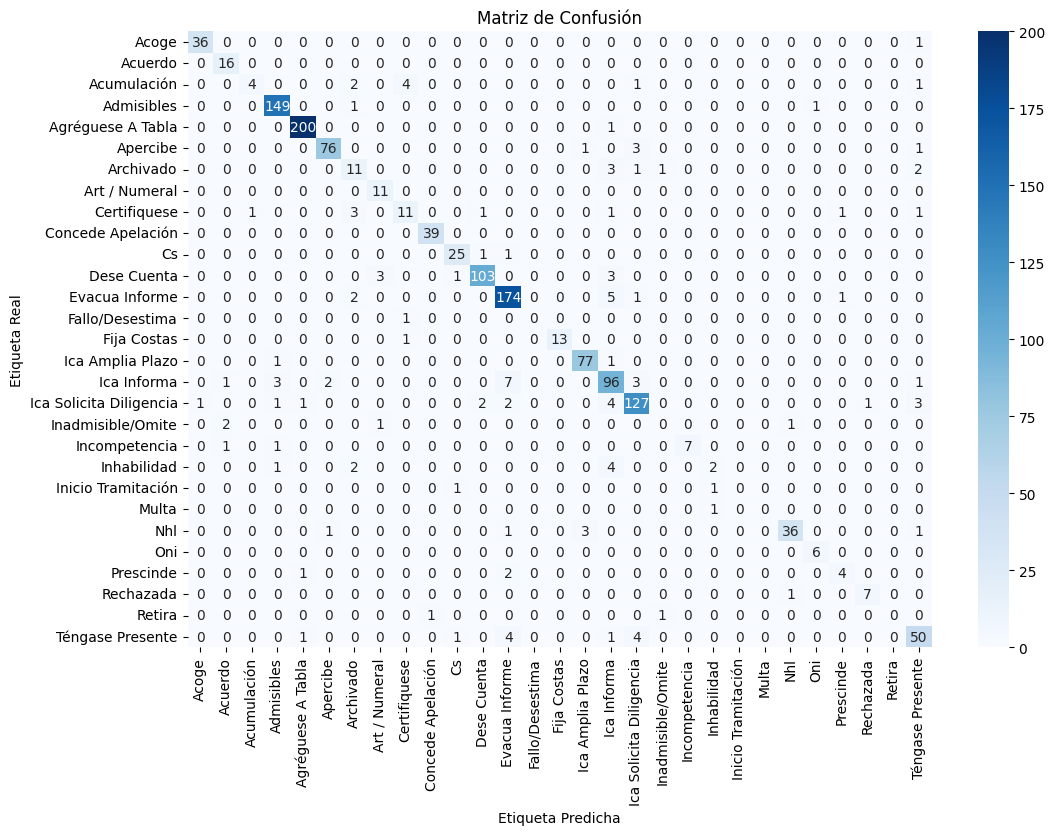

In [ ]:
df_clasificacion_sin_tratar = metricas_clases(X_test, model)

- El modelo en general se desempeña bastante bien con excepcion de las clases que tienen bajo soporte como:
    - Fallo/Desestima
    - Multa
    - Retira

- Hay clases que tienen metricas excepcionalmente buena como admisible, agreguese a tabla

## **3.1 DESBALANCEO DE CLASES**

In [ ]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


- Al mismo modelo anterior vamos a realizar un class_weights para ver si podemos mejorar las clases que tienen mal desempeño

### **3.1.2 Balanceando las clases con class_weights**

In [ ]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.0689 - loss: 3.4034 - val_accuracy: 0.2484 - val_loss: 3.2664 - learning_rate: 0.0010
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.2136 - loss: 3.1100 - val_accuracy: 0.3431 - val_loss: 2.1366 - learning_rate: 0.0010
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.3603 - loss: 2.7880 - val_accuracy: 0.4569 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.4822 - loss: 2.2809 - val_accuracy: 0.6021 - val_loss: 1.3325 - learning_rate: 0.0010
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5717 - loss: 1.7982 - val_accuracy: 0.7359 - val_loss: 1.0458 - learning_rate: 0.0010
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6486 - loss: 1.4487 - val_accuracy: 0.7779 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 7/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6882 - loss: 1

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.97      0.97      0.97        37
                Acuerdo       0.64      1.00      0.78        16
            Acumulación       0.77      0.83      0.80        12
             Admisibles       0.97      0.97      0.97       151
      Agréguese A Tabla       0.99      0.97      0.98       201
               Apercibe       0.93      0.95      0.94        81
              Archivado       0.65      0.61      0.63        18
          Art / Numeral       0.62      0.73      0.67        11
           Certifiquese       0.71      0.89      0.79        19
      Concede Apelación       0.95      0.95      0.95        39
                     Cs       0.93      0.93      0.93        27
            Dese Cuenta       0.99      0.92      0.95       110
         Evacua Informe       0.92      0.92      0.92       183
        Fallo/Desestima

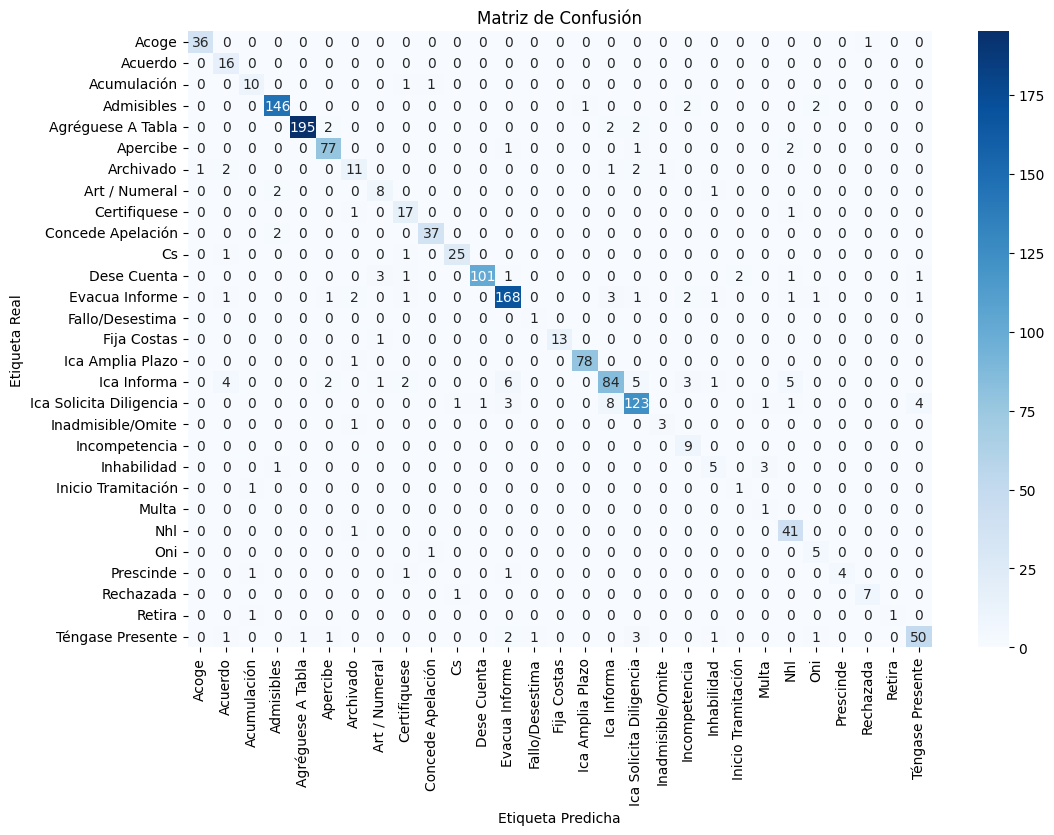

In [ ]:
df_classweights = metricas_clases(X_test, model)

## **2.3 Resumen hasta ahora**

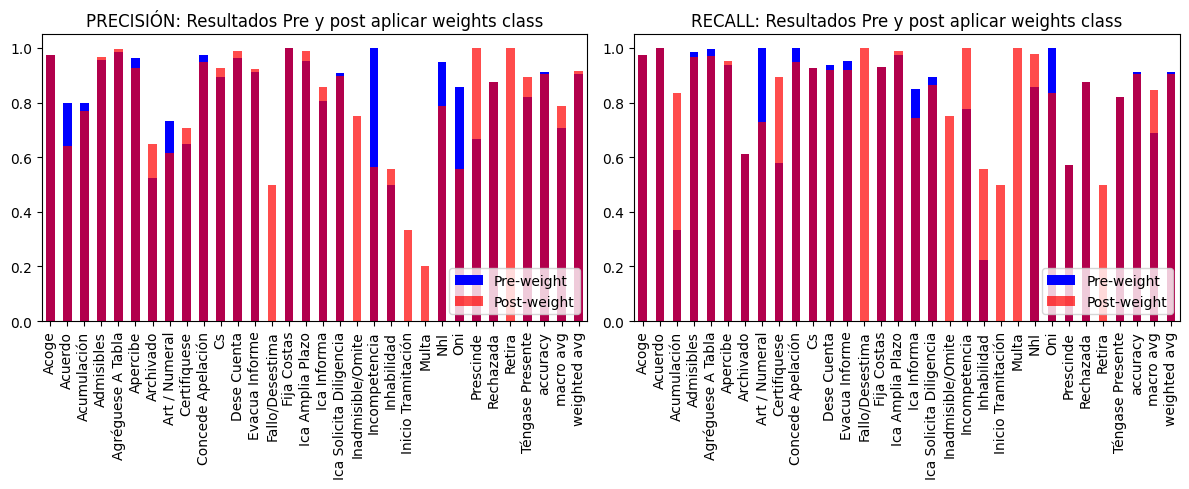

In [ ]:
df_resumen = pd.concat([df_clasificacion_sin_tratar, df_classweights], axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Precision
df_clasificacion_sin_tratar.iloc[:, 0].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[0])
df_classweights.iloc[:, 0].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[0])

ax[0].legend(loc='lower right')
ax[0].set_title('PRECISIÓN: Resultados Pre y post aplicar weights class')

# Recall
df_clasificacion_sin_tratar.iloc[:, 1].plot(kind='bar', label='Pre-weight', color='blue', ax=ax[1])
df_classweights.iloc[:, 1].plot(kind='bar', alpha=0.7, color='red', label='Post-weight', ax = ax[1])

ax[1].legend(loc='lower right')
ax[1].set_title('RECALL: Resultados Pre y post aplicar weights class')

plt.tight_layout()
plt.show()


### **Clases resultante con menor precision**
`Acuerdo`, `Acumulación`, `Apercibe`, `Archivado`, `Art / Numeral`, `ICA Solicita Diligencia`, `Inhabilidad`, `ONI`, `Precinde` y por último el macro avg

### **Clases mejoradas**

`Fallo/Desestima`, `Inadmisible/Omite`, `Multa`, `NHL`, `Téngase presente`

Logramos el cometido de poder sacar de 0 precision las clases con el class weights pero debido lo más probable al bajo soporte y ejemplos disponibles tenemos muy bajas **precisiones < 50 %**


### **MÉTRICA MÁS IMPORTANTE**

En nuestro caso la **precision** es lo más importante porque buscamos tratar de equivocarnos lo menos posible al clasificar los textos. Por esta razon o necesitamos unir alguna categoria con otra para disminuir la cantidad de clases y asi aumentar los ejemplos de las clases minoritarias o aplicar SMOTE con el riesgo de introducir ruido dentro de nuestros datos

### **CONCLUSIÓN**

#### Las clases con problemas son las siguientes:
- Acuerdo, Acumulación, Apercibe, Archivado, Certifiquese,  Fallo/Desestima, Fija Costas, Ica Solicita Diligencia, Inhabilidad, Multa, Nhl, Retira
Prescinde

Por lo tanto intetaremos aplicar **SMOTE** 


## APLICANDO SMOTE EN VEZ DE CLASS_WEIGHTS

In [ ]:

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')


X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42)
# 2. Convertir etiquetas de una codificación categórica (one-hot) a valores enteros
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero

# 3. Aplicar SMOTE para generar datos sintéticos
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_int)

# 4. Volver a convertir las etiquetas generadas por SMOTE a one-hot encoding
y_train_resampled = to_categorical(y_train_resampled, num_classes=y_categorical.shape[1])

# Verificar los tamaños después de SMOTE
print(f"Tamaño original: {X_train.shape}, Tamaño después de SMOTE: {X_train_resampled.shape}")

ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 4, n_samples = 4

In [ ]:

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)




c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:

# Resumen del modelo
model.summary()
history = model.fit(X_train_resampled, y_train_resampled, 
                    validation_data=(X_test, y_test), 
                    epochs=20, batch_size=32, 
                    callbacks=[early_stopping, reduce_lr])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.1675 - loss: 2.9206 - val_accuracy: 0.7133 - val_loss: 1.1587 - learning_rate: 0.0010
Epoch 2/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 33s 50ms/step - accuracy: 0.6457 - loss: 1.3723 - val_accuracy: 0.8128 - val_loss: 0.8214 - learning_rate: 0.0010
Epoch 3/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.7126 - loss: 1.1199 - val_accuracy: 0.8415 - val_loss: 0.7141 - learning_rate: 0.0010
Epoch 4/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.7551 - loss: 0.9652 - val_accuracy: 0.8575 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 5/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 38s 57ms/step - accuracy: 0.7797 - loss: 0.8653 - val_accuracy: 0.8702 - val_loss: 0.5881 - learning_rate: 0.0010
Epoch 6/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.7977 - loss: 0.7952 - val_accuracy: 0.8685 - val_loss: 0.6278 - learning_rate: 0.0010
Epoch 7/20
665/665 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.8139 - l

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.93      0.74      0.82        34
                Acuerdo       0.77      1.00      0.87        17
            Acumulación       0.53      0.69      0.60        13
             Admisibles       0.97      0.97      0.97       160
      Agréguese A Tabla       0.99      0.97      0.98       176
               Apercibe       0.82      0.84      0.83        43
              Archivado       0.86      0.92      0.89        13
          Art / Numeral       0.87      0.81      0.84        16
           Certifiquese       0.75      0.63      0.69        19
      Concede Apelación       1.00      0.97      0.98        30
                     Cs       0.91      0.84      0.88        25
            Dese Cuenta       0.93      0.94      0.94        70
         Evacua Informe       0.95      0.87      0.91       139
        Fallo/Desestima

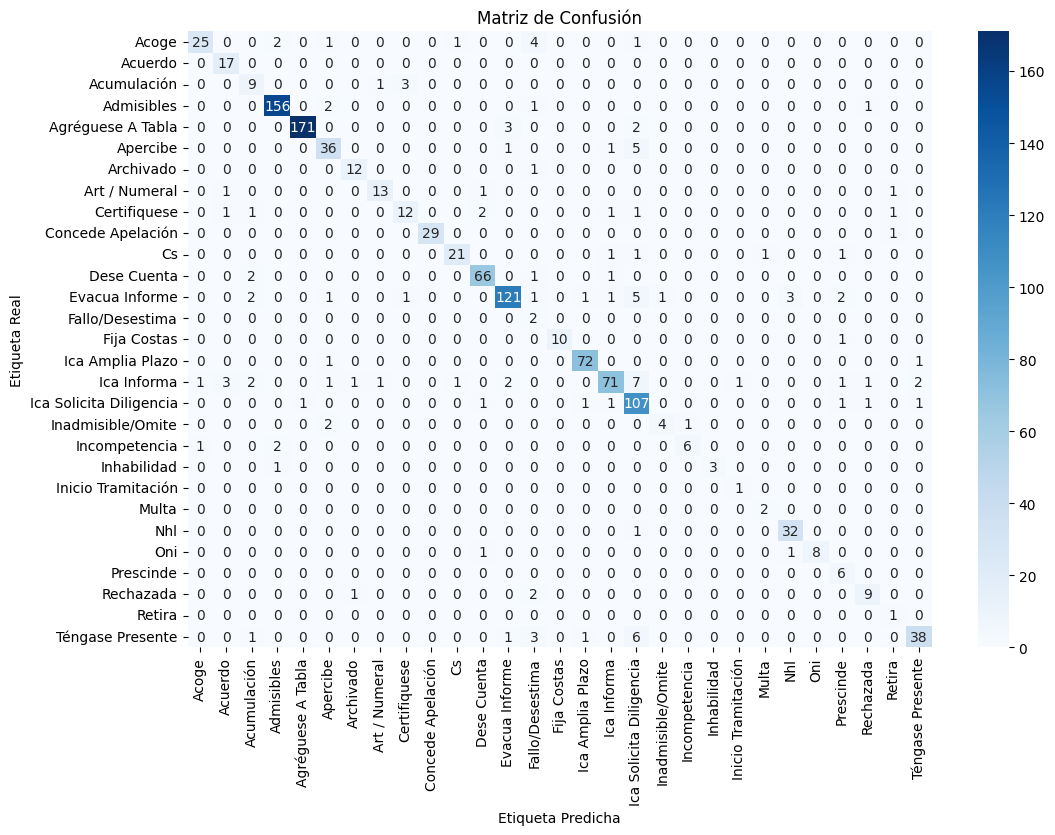

In [ ]:
df_smote = metricas_clases(X_test, model)

In [ ]:
df_resumen = pd.concat([
    df_clasificacion_sin_tratar.add_suffix('_SIN_TRATAR'),
    df_classweights.add_suffix('_CLASS_WEIGHT'),
    df_smote.add_suffix('_SMOTE')
], axis=1)

In [ ]:
df_resumen

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acoge,1.000000,0.903846,0.949495,52.000000,0.979167,0.903846,0.940000,52.00000,0.925926,0.735294,0.819672,34.000000
Acuerdo,0.956522,1.000000,0.977778,22.000000,0.880000,1.000000,0.936170,22.00000,0.772727,1.000000,0.871795,17.000000
Acumulación,0.928571,0.812500,0.866667,16.000000,0.700000,0.875000,0.777778,16.00000,0.529412,0.692308,0.600000,13.000000
Admisibles,0.991379,0.987124,0.989247,233.000000,0.995633,0.978541,0.987013,233.00000,0.968944,0.975000,0.971963,160.000000
Agréguese A Tabla,0.992095,0.996032,0.994059,252.000000,1.000000,0.988095,0.994012,252.00000,0.994186,0.971591,0.982759,176.000000
Apercibe,0.931507,0.971429,0.951049,70.000000,0.857143,0.942857,0.897959,70.00000,0.818182,0.837209,0.827586,43.000000
Archivado,0.950000,0.863636,0.904762,22.000000,0.900000,0.818182,0.857143,22.00000,0.857143,0.923077,0.888889,13.000000
Art / Numeral,0.944444,0.772727,0.850000,22.000000,0.950000,0.863636,0.904762,22.00000,0.866667,0.812500,0.838710,16.000000
Certifiquese,1.000000,0.580645,0.734694,31.000000,0.928571,0.419355,0.577778,31.00000,0.750000,0.631579,0.685714,19.000000
Concede Apelación,0.927273,1.000000,0.962264,51.000000,0.925926,0.980392,0.952381,51.00000,1.000000,0.966667,0.983051,30.000000


In [ ]:
df_resumen[['precision_SIN_TRATAR', 'precision_CLASS_WEIGHT', 'precision_SMOTE', 'support_SIN_TRATAR', 'support_CLASS_WEIGHT', 'support_SMOTE' ]]

,precision_SIN_TRATAR,precision_CLASS_WEIGHT,precision_SMOTE,support_SIN_TRATAR,support_CLASS_WEIGHT,support_SMOTE
Acoge,1.000000,0.979167,0.925926,52.000000,52.00000,34.000000
Acuerdo,0.956522,0.880000,0.772727,22.000000,22.00000,17.000000
Acumulación,0.928571,0.700000,0.529412,16.000000,16.00000,13.000000
Admisibles,0.991379,0.995633,0.968944,233.000000,233.00000,160.000000
Agréguese A Tabla,0.992095,1.000000,0.994186,252.000000,252.00000,176.000000
Apercibe,0.931507,0.857143,0.818182,70.000000,70.00000,43.000000
Archivado,0.950000,0.900000,0.857143,22.000000,22.00000,13.000000
Art / Numeral,0.944444,0.950000,0.866667,22.000000,22.00000,16.000000
Certifiquese,1.000000,0.928571,0.750000,31.000000,31.00000,19.000000
Concede Apelación,0.927273,0.925926,1.000000,51.000000,51.00000,30.000000


In [ ]:
umbral_soporte = df_resumen['support_SMOTE'].median()  # Se puede ajustar según la distribución

# Filtrar las clases con bajo soporte en SMOTE
clases_bajo_soporte = df_resumen[df_resumen['support_SMOTE'] < umbral_soporte]
clases_bajo_soporte

,precision_SIN_TRATAR,recall_SIN_TRATAR,f1-score_SIN_TRATAR,support_SIN_TRATAR,precision_CLASS_WEIGHT,recall_CLASS_WEIGHT,f1-score_CLASS_WEIGHT,support_CLASS_WEIGHT,precision_SMOTE,recall_SMOTE,f1-score_SMOTE,support_SMOTE
Acuerdo,0.956522,1.000000,0.977778,22.000000,0.880000,1.000000,0.936170,22.00000,0.772727,1.000000,0.871795,17.000000
Acumulación,0.928571,0.812500,0.866667,16.000000,0.700000,0.875000,0.777778,16.00000,0.529412,0.692308,0.600000,13.000000
Archivado,0.950000,0.863636,0.904762,22.000000,0.900000,0.818182,0.857143,22.00000,0.857143,0.923077,0.888889,13.000000
Art / Numeral,0.944444,0.772727,0.850000,22.000000,0.950000,0.863636,0.904762,22.00000,0.866667,0.812500,0.838710,16.000000
Fallo/Desestima,0.666667,0.666667,0.666667,3.000000,0.428571,1.000000,0.600000,3.00000,0.133333,1.000000,0.235294,2.000000
Fija Costas,1.000000,0.950000,0.974359,20.000000,1.000000,0.950000,0.974359,20.00000,1.000000,0.909091,0.952381,11.000000
Inadmisible/Omite,1.000000,0.545455,0.705882,11.000000,0.777778,0.636364,0.700000,11.00000,0.800000,0.571429,0.666667,7.000000
Incompetencia,1.000000,0.727273,0.842105,11.000000,0.785714,1.000000,0.880000,11.00000,0.857143,0.666667,0.750000,9.000000
Inhabilidad,0.800000,0.666667,0.727273,6.000000,0.714286,0.833333,0.769231,6.00000,1.000000,0.750000,0.857143,4.000000
Inicio Tramitación,0.000000,0.000000,0.000000,2.000000,1.000000,0.500000,0.666667,2.00000,0.500000,1.000000,0.666667,1.000000


### **CONCLUSION**

Según lo observado con la aplicación del SMOTE no se observa una mejora considerable en las metricas que nos interesa de las clases que tienen menor soporte. Aplicar ya sea un undersampling o un data augmentation podria ser una buena opción. Considerando que ya se aplicó un tratamiento a los datos en si, vamos a tratar de realizar un aumento de datos

## **3. DATA AUGMENTATION**

In [28]:
from data_augmentation.main import main
df_augmented = main()
df_augmented.head()



,frase,etiqueta
0,"Por falta de respuesta, se hace efectivo el Ap...",Apercibe
1,Tngse.cúmplase csomite,Cs
2,Suspensión vista de común acuerdo art. 165 N° ...,Acuerdo
3,La infracción de negativa injustificada de cob...,Multa
4,La comisión de falta de transparencia en contr...,Multa


In [29]:
df_augmented['etiqueta'] = df_augmented['etiqueta'].str.replace('Acogida', 'Acoge')

In [30]:
df_augmented.columns=['descripcion', 'CLASIFICACION_CORRECTA']

In [31]:
df_augmented['CLASIFICACION_CORRECTA'].value_counts()

CLASIFICACION_CORRECTA
Acumulación                300
Nhl                        293
Inadmisible/Omite          291
Fija Costas                291
Prescinde                  289
Archivado                  278
Inhabilidad                272
Retira                     272
Multa                      268
Ica Solicita Diligencia    268
Certifiquese               268
Acoge                      259
Rechazada                  257
Incompetencia              223
Cs                         200
Apercibe                   182
Art / Numeral              169
Concede Apelación          153
Inicio Tramitación         139
Oni                        138
Acuerdo                    109
Téngase Presente            88
Fallo/Desestima             80
Name: count, dtype: int64

In [32]:
df_csv2 = df_csv.copy()

In [33]:


# Añadir las nuevas filas al DataFrame existente
df = pd.concat([df_csv2, df_augmented], ignore_index=True)

# Mostrar los últimos registros para verificar
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,rol,corte,fecha,folio,tramite,descripcion,fecha_ingreso,CLASIFICACION_CORRECTA,dup_count,CLASIFICACION_NUM
0,7834-2023,Concepción,09/11/2023,13.0,Resolución,"Atendido el mérito de los antecedentes, ofície...",02/05/2023,Apercibe,1.0,5.0
1,NaN,NaN,NaN,NaN,NaN,En vista y consideración lo informado por la C...,NaN,Concede Apelación,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,"Por falta de respuesta, se hace efectivo el Ap...",NaN,Apercibe,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,Al folio 83: declara inadm,NaN,Incompetencia,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,No ha lugar lo Pde. por lo que se desestima,NaN,Fallo/Desestima,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9763,NaN,NaN,NaN,NaN,NaN,La corte ha omte proncunc. la recurso por falt...,NaN,Inadmisible/Omite,NaN,NaN
9764,NaN,NaN,NaN,NaN,NaN,"Retira el demanda, por por no dar cumplimiento...",NaN,Retira,NaN,NaN
9765,NaN,NaN,NaN,NaN,NaN,Tgse. pres. por cumplida lo Pde. por la corte,NaN,Téngase Presente,NaN,NaN
9766,13365-2023,Temuco,19/03/2024,12.0,Sentencia,"Acogida con costas, 50.000",13/09/2023,Acoge,1.0,0.0


In [34]:
total_clases_after = len(df['CLASIFICACION_CORRECTA'].unique())
print(f'Total de clases: {total_clases_after}')

Total de clases: 29


In [35]:
df['CLASIFICACION_CORRECTA'].unique()

array(['Apercibe', 'Concede Apelación', 'Incompetencia',
       'Fallo/Desestima', 'Evacua Informe', 'Cs', 'Oni',
       'Agréguese A Tabla', 'Rechazada', 'Multa', 'Prescinde',
       'Dese Cuenta', 'Fija Costas', 'Admisibles', 'Archivado',
       'Ica Informa', 'Téngase Presente', 'Ica Solicita Diligencia',
       'Acumulación', 'Acoge', 'Ica Amplia Plazo', 'Art / Numeral',
       'Acuerdo', 'Inhabilidad', 'Nhl', 'Certifiquese', 'Retira',
       'Inicio Tramitación', 'Inadmisible/Omite'], dtype=object)

In [36]:
df = df.drop_duplicates(subset=['descripcion', 'CLASIFICACION_CORRECTA'])


In [37]:
df.shape

(7722, 10)

In [38]:
sentences =  [ line for line in df['descripcion'].values if line != 'Unknown']
clean_data = [cleaning_data(t) for t in sentences]


In [39]:
clean_data = [
    ' '.join([word for word in sentence.split() if word.lower() not in stop_words_es])
    for sentence in clean_data
]

# Imprimir el resultado
clean_data[:10]

['atendido merito antecedentes oficiese isapre recurrida fin informe manera encuentra dando cumplimiento orden innovar evacue dentro plazo cinco dias habiles debiendo adjuntar antecedentes existan poder asunto motivo recurso debera remitir posible forma digitalizada bajo apercibimiento caso incumplimiento aplicarle alguna medidas contempla 15 auto acordado excma corte suprema tramitacion fallo recurso proteccion garantias constitucionales oficiese',
 'vista consideracion informado corte apelaciones ca concedase recurso vista',
 'falta respuesta hace efectivo aperc',
 'folio 83 declara inadm',
 'lugar pde desestima',
 'ev informe pase presidencia',
 'cumplase cs litis pendencia',
 'corte puerto montt aceptada orden innovara resolucion folio 11 aceptada orden innovar',
 'agreguese extraordinariamente tabla martes 02 julio ev informe relacion',
 'rechazao recurso costas extemporaneidad']

In [ ]:
with open('clean_data.txt', 'w') as f:
    for sentence in clean_data:
        f.write(sentence + '\n')  # Escribir cada oración seguida de un salto de línea

In [ ]:
with open('clean_data.txt', 'r', encoding='utf-8') as f:
    loaded_data = f.readlines()

# Eliminar los saltos de línea (\n) al final de cada oración
clean_data = [line.strip() for line in loaded_data]

clean_data

['tp inf cumpl desarchivo cumplimiento atencion dispuesto autos',
 'certif acuerdo',
 'desestima obrado',
 'prescinde fiscala presentar pruebas',
 'atendido merito acuerdo tribunal pleno diez julio dos mil veintitres dispone tramitacion presente causa bajo c digo administrativo pr16 debiendo efectuarse cambio respectivo unidad asesor sitcorte requierase unidad cuenta mentada modificacion',
 'concede recurso interconexion',
 'compl fallo desestima ges',
 'pide informe cump sentencia',
 'costas desestiman',
 'concede plazo',
 'pide informe cumpl sentencia',
 'inhabilidad juez corte apelaciones fundamenta recibir beneficios partes',
 'nota acuerdo redaccion camilo alvarez',
 'ges evacuado informe r',
 'tengase presente',
 'interpuesto recurso p',
 'inadmisible pb',
 'informado recurrida pidase cuenta perjuicio reiterese peticion informe tenor recurso dentro plazo cinco dias habiles bajo apercibimiento caso incumplimiento prescindir mismo aplicarle alguna medidas contempla 15 auto acordado

In [40]:

unique_words = set(word for sentence in clean_data for word in sentence.split())
total_words = len(unique_words) + 1 # Total de palabras

print(f'Las palabras unicas son: {total_words}')

Las palabras unicas son: 3439


In [41]:

# 1. Convertir etiquetas de texto a números
label_encoder = LabelEncoder()
df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


# 2. Convertir etiquetas numéricas a one-hot encoding
y_categorical = to_categorical(df['CLASIFICACION_NUM'])


C:\Users\kev_g\AppData\Local\Temp\ipykernel_23092\2690493204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CLASIFICACION_NUM'] = label_encoder.fit_transform(df['CLASIFICACION_CORRECTA'])


In [42]:
# Tokenización
tokenizer = Tokenizer(num_words=total_words, oov_token="<OOV>")#2619



tokenizer.fit_on_texts(clean_data)

# Al vocabulario total que tenemos le sumamos 1 para asegurarnos que incluya el indice 0 del pading (tokenizer.word_index = dict)
total_words = len(tokenizer.word_index) + 1 

sequences = tokenizer.texts_to_sequences(clean_data)

max_sequence_len = max([len(x) for x in sequences])



In [43]:
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='pre')
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y_categorical, test_size=0.2, random_state=42,  stratify=df['CLASIFICACION_NUM'])

In [44]:
from sklearn.metrics import classification_report, confusion_matrix

def metricas_clases(X_test, y_test ,model):

    """
    Función que genera probabilidades para el conjunto de prueba y las combierte a las clases predichas. También genera informe de clasificación y matriz de confusion.
    return: Retorna un dataframe con el clasification report.
    """
    # Predecir las probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)

    # Convertir las probabilidades a clases predichas
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Obtener las etiquetas reales
    y_true = np.argmax(y_test, axis=1)

    # Generar el informe de clasificación
    print("Informe de clasificación:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))
    
    classification_report_dict = classification_report(y_true, y_pred,  labels=np.arange(28)
        ,target_names=label_encoder.classes_, output_dict=True)

    df_cr = pd.DataFrame(classification_report_dict).transpose()

    # Generar la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.title('Matriz de Confusión')
    plt.show()

    return df_cr

### *QUITANDO EL SMOTE*

In [ ]:
# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(LSTM(256, return_sequences=False, kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.5))

# Capa densa
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.0702 - loss: 3.3034 - val_accuracy: 0.4093 - val_loss: 2.0254 - learning_rate: 0.0010
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.4724 - loss: 1.7631 - val_accuracy: 0.7733 - val_loss: 0.8356 - learning_rate: 0.0010
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.7216 - loss: 0.9467 - val_accuracy: 0.8672 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8257 - loss: 0.6246 - val_accuracy: 0.8899 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step - accuracy: 0.8698 - loss: 0.4930 - val_accuracy: 0.9054 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8984 - loss: 0.3869 - val_accuracy: 0.9210 - val_loss: 0.4221 - learning_rate: 0.0010
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9248 - l

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9116 - loss: 0.3930
Test Loss: 0.4181475043296814, Test Accuracy: 0.9158031344413757


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.97      0.98        65
                Acuerdo       0.87      0.93      0.90        29
            Acumulación       0.94      0.95      0.95        64
             Admisibles       0.85      0.96      0.90        52
      Agréguese A Tabla       1.00      1.00      1.00        67
               Apercibe       0.94      0.94      0.94        72
              Archivado       1.00      0.92      0.96        61
          Art / Numeral       0.93      0.98      0.95        42
           Certifiquese       0.94      0.94      0.94        63
      Concede Apelación       0.97      0.93      0.95        42
                     Cs       0.85      0.71      0.78        49
            Dese Cuenta       0.96      0.79      0.87        33
         Evacua Informe       0.81      0.68      0.74        71
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


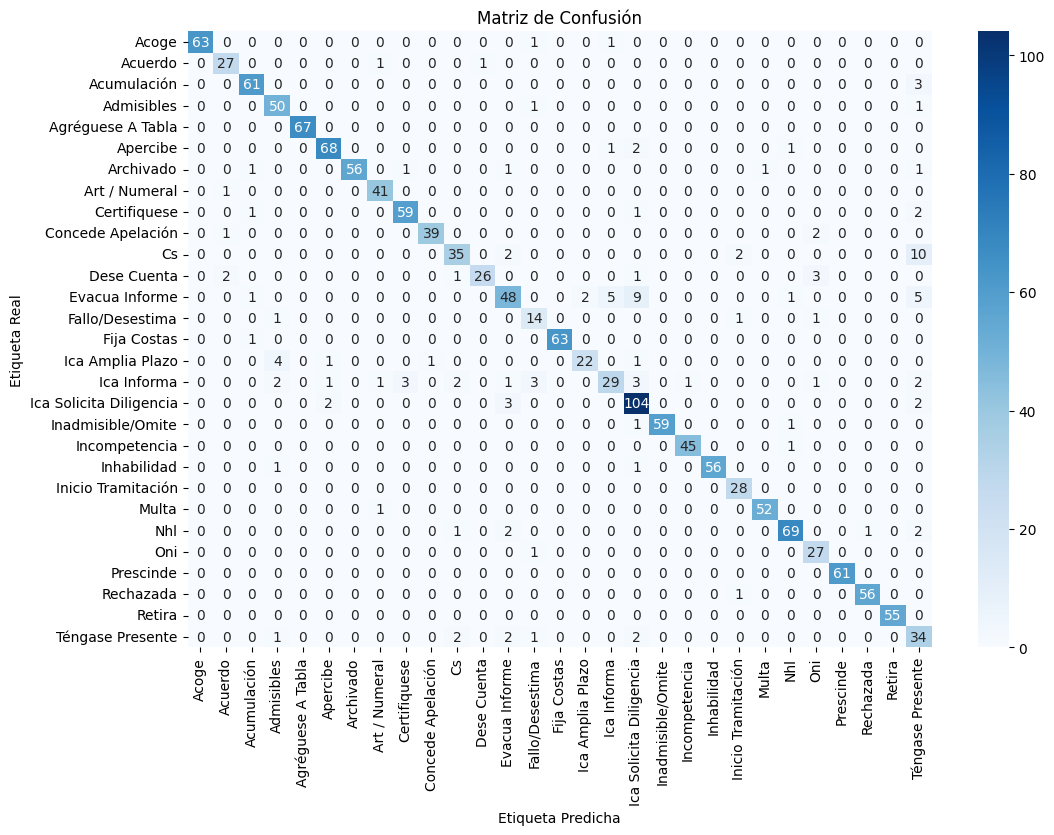

In [ ]:
df_smote_3 = metricas_clases(X_test, y_test, model)

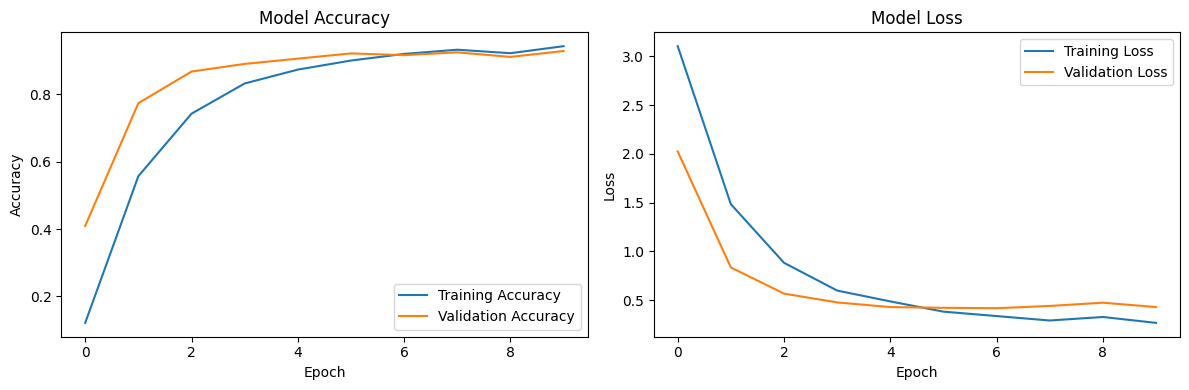

In [ ]:
import matplotlib.pyplot as plt

# Graficar la precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=50, input_length=max_sequence_len))

# Capa LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.5))

# Capa densa
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.4))

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)





c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)

class_weights_dict = dict(enumerate(class_weights))

In [ ]:

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.0686 - loss: 3.3150 - val_accuracy: 0.4715 - val_loss: 1.8621 - learning_rate: 0.0010
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.4723 - loss: 1.7823 - val_accuracy: 0.8420 - val_loss: 0.8216 - learning_rate: 0.0010
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.7575 - loss: 0.9279 - val_accuracy: 0.8808 - val_loss: 0.5216 - learning_rate: 0.0010
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.8676 - loss: 0.5698 - val_accuracy: 0.8828 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - accuracy: 0.9026 - loss: 0.4454 - val_accuracy: 0.9093 - val_loss: 0.4641 - learning_rate: 0.0010
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9270 - loss: 0.3457 - val_accuracy: 0.8938 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9304 - l

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       0.95      0.97      0.96        65
                Acuerdo       0.94      1.00      0.97        29
            Acumulación       0.95      0.89      0.92        64
             Admisibles       0.90      0.90      0.90        52
      Agréguese A Tabla       0.99      1.00      0.99        67
               Apercibe       0.97      0.92      0.94        72
              Archivado       0.92      0.92      0.92        61
          Art / Numeral       0.98      1.00      0.99        42
           Certifiquese       0.98      0.94      0.96        63
      Concede Apelación       0.91      0.95      0.93        42
                     Cs       0.89      0.69      0.78        49
            Dese Cuenta       0.82      0.97      0.89        33
         Evacua Informe       0.88      0.72      0.79        71
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


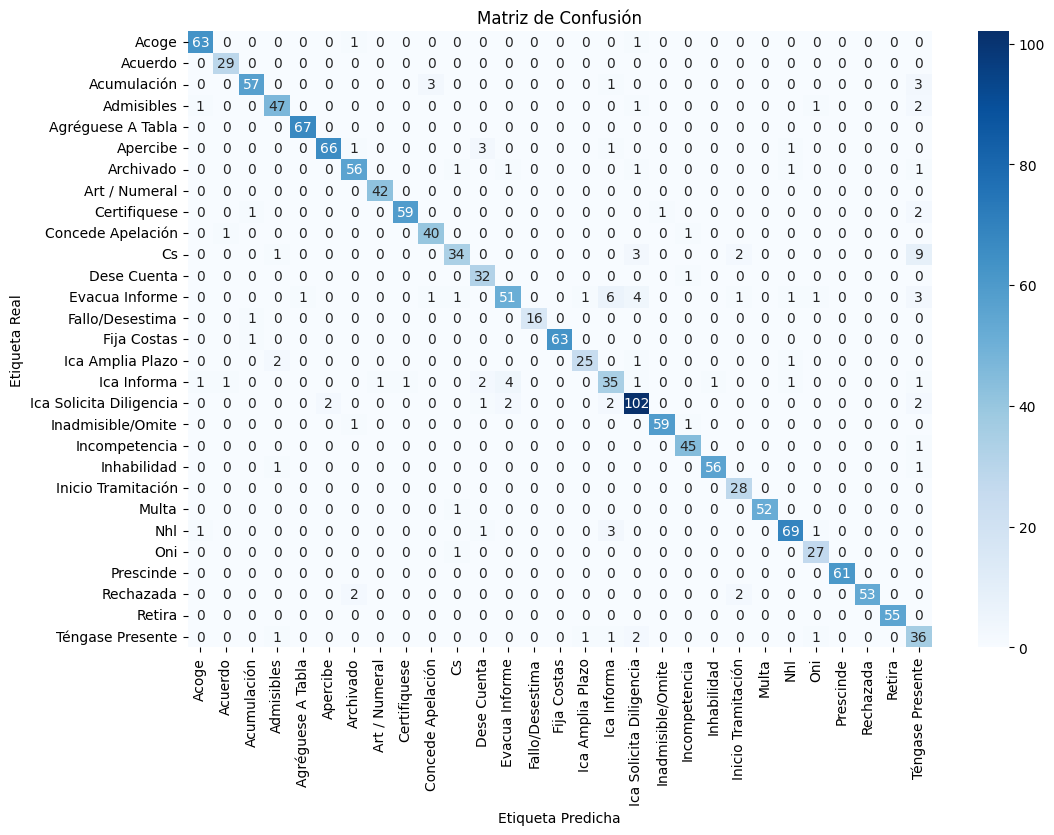

In [ ]:
df_balanceweights_3 = metricas_clases(X_test, y_test, model)

In [48]:
# Nuevo texto para probar
new_description = "agregado a la tabla del 28 de junio 2025"

# Limpieza (usa la misma función que creaste anteriormente)
cleaned_description = cleaning_data(new_description)

words = cleaned_description.split()
filtered_words = [word for word in words if word.lower() not in stop_words_es]
cleaned_no_stop = ' '.join(filtered_words)
print(cleaned_no_stop)

# Tokenización del texto
tokenized_description = tokenizer.texts_to_sequences([cleaned_no_stop])

# Padding para que tenga la misma longitud que las secuencias de entrenamiento
padded_description = pad_sequences(tokenized_description, maxlen=max_sequence_len, padding='pre')
# Realizar la predicción
prediction = model.predict(padded_description)

# Ordenar las probabilidades de mayor a menor y obtener los índices de las 3 clases más probables
top_3_indices = prediction[0].argsort()[-3:][::-1]

# Mapear índices a etiquetas originales
top_3_labels = label_encoder.inverse_transform(top_3_indices)

# Obtener las probabilidades correspondientes
top_3_probabilities = prediction[0][top_3_indices]
print("Top 3 predicciones más probables:")
for i in range(3):
    print(f"{i+1}. Clase: {top_3_labels[i]} - Probabilidad: {top_3_probabilities[i]:.2f}")


agregado tabla 28 junio 2025
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Top 3 predicciones más probables:
1. Clase: Agréguese A Tabla - Probabilidad: 0.92
2. Clase: Cs - Probabilidad: 0.06
3. Clase: Acumulación - Probabilidad: 0.01


In [ ]:
# Guardar modelo
model.save('modelo_final.h5')


In [ ]:
import pickle

# Guardar el tokenizer
with open('tokenizer_2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('label_encoder_2.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
history2 = model.fit(
    X_train, 
    y_train,
    epochs=10, 
    batch_size=32, 
    validation_data = (X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1178 - loss: 3.1011 - val_accuracy: 0.3435 - val_loss: 2.0698 - learning_rate: 0.0010
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.3868 - loss: 1.9588 - val_accuracy: 0.6804 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.6483 - loss: 1.1591 - val_accuracy: 0.8341 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.7795 - loss: 0.7868 - val_accuracy: 0.9062 - val_loss: 0.4543 - learning_rate: 0.0010
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.8431 - loss: 0.6211 - val_accuracy: 0.9378 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8839 - loss: 0.4485 - val_accuracy: 0.9423 - val_loss: 0.3192 - learning_rate: 0.0010
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9083 - l

In [ ]:
df_csv[['text1', 'text2', 'text3', 'text4', 'text5']] = df_csv['descripcion'].str.split('//', expand=True)

In [ ]:
df_filled = df_csv.fillna('')


In [ ]:
unique_text1 = set(df_filled['text1'])
unique_text2 = set(df_filled['text2'])
unique_text3 = set(df_filled['text3'])
unique_text4 = set(df_filled['text4'])

In [ ]:
all_values = np.concatenate([
    list(unique_text1),
    list(unique_text2),
    list(unique_text3),
    list(unique_text4)
])
all_values = np.array(list(set().union(unique_text1, unique_text2, unique_text3, unique_text4)))

# Obtener valores únicos
unique_values = np.unique(all_values)

print("Valores únicos concatenados:")
print(unique_values)

Valores únicos concatenados:
['' '  Ev. Informe. En relación'
 '  Proveyendo escrito “Ampliación de plazo”: Como se pide, por el tiempo solicitado.'
 ... 'vt3. Cumplimiento con Citación' 'zoom.us/j/92407184252'
 'ऀHabiéndose incurrido en un error involuntario en el nombre de la recurrida de la resolución de fecha cinco de noviembre del año en curso, se rectifica en el sentido que donde dice “Isapre Consalud S.A.” debe decir “Isapre Nueva Mas vida”, manteniéndose inalterada todo lo demás. ऀAtendido lo resuelto precedentemente notifíquese a la Isapre Nueva Mas vida S.A. de acuerdo a lo ordenado en la resolución folio 2, por la vía más rápida debiendo la Sra. Secretaria velar por su oportuno cumplimiento. ऀAl escrito folio 16: Estese al mérito de lo resuelto precedentemente. ऀSuspéndase el decreto de autos en relación.']


In [ ]:
for word in unique_values:
    if word.strip() == '':  # Ignorar cadenas vacías
        continue
    
    

    print(cleaned_word)

  Ev. Informe. En relación
  Proveyendo escrito “Ampliación de plazo”: Como se pide, por el tiempo solicitado.
 A Sala Previo Sorteo
 A la presentación de folio 1: Existiendo discordancia entre el nombre de la Isapre contenido en los documentos acompañados y el nombre señalado en el cuerpo del recurso, para resolver, aclárese el nombre de la Isapre contra la cual recurre, dentro de cinco días hábiles, bajo apercibimiento, en caso de incumplimiento, de archivar estos antecedentes.
 A lo principal y al otrosí: No habiéndosele conferido poder a la abogada por la recurrente, no ha lugar por innecesario.
 A lo principal y otro si por acompañado el mandato al tercer otrosi como se pide 
 A lo principal y otrosí: Como se pide a los alegatos. Respecto a la comparecencia remota, atendido el mérito de los antecedentes, constando el domicilio del solicitante, fuera de las ciudades de Antofagasta y Mejillones, y de acuerdo con lo establecido en el Auto Acordado de fecha 7 de octubre del año en cur

In [ ]:
import pandas as pd
import numpy as np

# Supongamos que ya tienes estas variables definidas:
# model, tokenizer, label_encoder, unique_values, max_sequence_len

# Crear un DataFrame para almacenar los resultados
results = []

# Clasificar cada palabra única
for word in unique_values:
    if word.strip() == '':  # Ignorar cadenas vacías
        continue
    
    # Limpieza del texto (si es necesario)
    cleaned_description = cleaning_data(word)
    words = cleaned_description.split()
    filtered_words = [word for word in words if word.lower() not in stop_words_es]
    cleaned_no_stop = ' '.join(filtered_words)
    # Tokenización del texto
    tokenized_word = tokenizer.texts_to_sequences([cleaned_no_stop])
    
    # Padding para que tenga la misma longitud que las secuencias de entrenamiento
    padded_word = pad_sequences(tokenized_word, maxlen=max_sequence_len, padding='pre')
    
    # Realizar la predicción
    prediction = model.predict(padded_word)
    
    # Obtener las 3 clases más probables
    top_3_indices = prediction[0].argsort()[-3:][::-1]
    top_3_labels = label_encoder.inverse_transform(top_3_indices)
    top_3_probabilities = prediction[0][top_3_indices]
    
    # Almacenar los resultados
    results.append({
        'Palabra': word,
        'Clase 1': top_3_labels[0],
        'Probabilidad 1': top_3_probabilities[0],
        'Clase 2': top_3_labels[1],
        'Probabilidad 2': top_3_probabilities[1],
        'Clase 3': top_3_labels[2],
        'Probabilidad 3': top_3_probabilities[2]
    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Exportar el DataFrame a un archivo Excel
results_df.to_excel('clasificacion_palabras.xlsx', index=False)

print("Clasificación exportada a 'clasificacion_palabras.xlsx'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [ ]:
label_encoder.classes_

array(['Acoge', 'Acuerdo', 'Acumulación', 'Admisibles',
       'Agréguese A Tabla', 'Apercibe', 'Archivado', 'Art / Numeral',
       'Certifiquese', 'Concede Apelación', 'Cs', 'Dese Cuenta',
       'Evacua Informe', 'Fallo/Desestima', 'Fija Costas',
       'Ica Amplia Plazo', 'Ica Informa', 'Ica Solicita Diligencia',
       'Inadmisible/Omite', 'Incompetencia', 'Inhabilidad',
       'Inicio Tramitación', 'Multa', 'Nhl', 'Oni', 'Prescinde',
       'Rechazada', 'Retira', 'Téngase Presente'], dtype=object)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Definición del modelo
model = Sequential()

# Capa de Embedding
model.add(Embedding(input_dim=total_words, output_dim=128, input_length=max_sequence_len))

# Capa LSTM Bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.0005))))
model.add(Dropout(0.4))

# Capa densa
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Capa de salida
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compilación del modelo
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [46]:
y_train_int = y_train.argmax(axis=1)  # De one-hot a entero
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)

class_weights_dict = dict(enumerate(class_weights))
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, 
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.3073 - loss: 2.7793 - val_accuracy: 0.9049 - val_loss: 2.6580 - learning_rate: 0.0010
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8934 - loss: 0.7703 - val_accuracy: 0.9301 - val_loss: 0.8953 - learning_rate: 0.0010
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9518 - loss: 0.3953 - val_accuracy: 0.9437 - val_loss: 0.3375 - learning_rate: 0.0010
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9670 - loss: 0.2787 - val_accuracy: 0.9411 - val_loss: 0.2970 - learning_rate: 0.0010
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9775 - loss: 0.2179 - val_accuracy: 0.9372 - val_loss: 0.3117 - learning_rate: 0.0010
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9799 - loss: 0.1762 - val_accuracy: 0.9411 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9801 - loss: 0.

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Informe de clasificación:
                         precision    recall  f1-score   support

                  Acoge       1.00      0.97      0.98        66
                Acuerdo       1.00      0.97      0.98        30
            Acumulación       0.95      0.95      0.95        64
             Admisibles       0.96      0.90      0.93        52
      Agréguese A Tabla       0.97      0.97      0.97        68
               Apercibe       1.00      0.99      0.99        72
              Archivado       1.00      0.97      0.98        64
          Art / Numeral       1.00      0.95      0.97        39
           Certifiquese       0.97      0.98      0.98        62
      Concede Apelación       0.98      0.98      0.98        42
                     Cs       0.82      0.86      0.84        49
            Dese Cuenta       0.82      0.97      0.89        33
         Evacua Informe       0.89      0.69      0.78        71
        Fallo/Desestima

c:\DEEP_LEARNING\Project_1\myenv\lib\site-packages\sklearn\metrics\_classification.py:2687: UserWarning: labels size, 28, does not match size of target_names, 29
  warnings.warn(


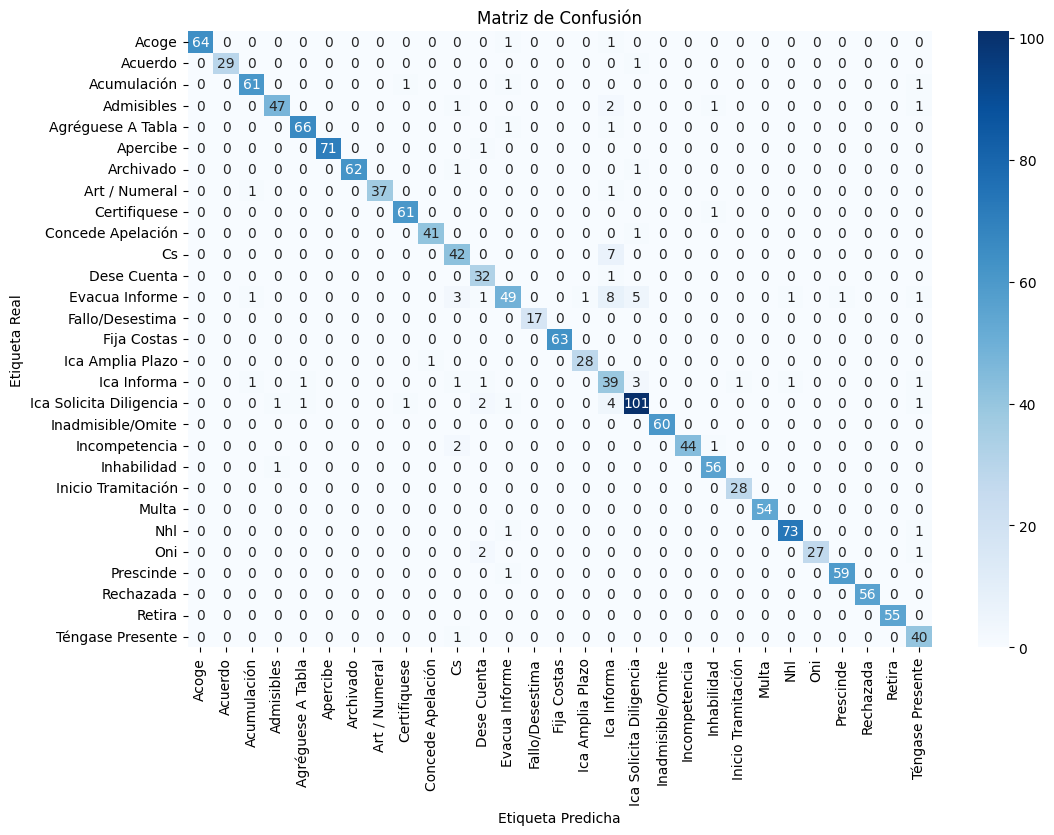

In [47]:
df_balanceweights_4 = metricas_clases(X_test, y_test, model)